Паркинсоновата болест е прогресивно невролошко нарушување кое влијае на движењето. Вкочанетост, тремор и забавување на движењата може да бидат знаци на Паркинсонова болест. Со користење на модели на машинско учење може да ја предвидиме Паркинсоновата болест.

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,classification_report,precision_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

Вчитување на податочното множество и запознавање со истото.

In [31]:
df = pd.read_csv('parkinsons.data')

За подобро да го разбереме множеството податоци, користиме некои вградени функции од библиотеката Pandas. Овие функции ни помагаат да ја провериме структурата, типовите на податоци и статистичките својства на множеството податоци.

- df.info(): Го прикажува вкупниот број на редови и колони, типовите на податоци на секоја колона и бројот на не-нулти вредности. Ова помага да се идентификуваат недостасувачките податоци и типовите на колони.
- df.describe().T: Обезбедува транспониран статистички преглед на нумерички колони, вклучувајќи ја средната вредност, стандардната девијација, минималните и максималните вредности, како и квартили. Ова ни помага да ја разбереме распределбата на податоците.
- df.isnull().sum().sum(): Го проверува вкупниот број на недостасувачки вредности во множеството податоци. Ако ова врати 0, тоа значи дека нема недостасувачки вредности. Ако има нулти/недостасувачки вредности, тогаш започнуваме со процесот на чистење на податоци за да ги обработиме тие вредности.

In [33]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [35]:
print(df.describe())

       MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
count   195.000000    195.000000    195.000000      195.000000   
mean    154.228641    197.104918    116.324631        0.006220   
std      41.390065     91.491548     43.521413        0.004848   
min      88.333000    102.145000     65.476000        0.001680   
25%     117.572000    134.862500     84.291000        0.003460   
50%     148.790000    175.829000    104.315000        0.004940   
75%     182.769000    224.205500    140.018500        0.007365   
max     260.105000    592.030000    239.170000        0.033160   

       MDVP:Jitter(Abs)    MDVP:RAP    MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
count        195.000000  195.000000  195.000000  195.000000    195.000000   
mean           0.000044    0.003306    0.003446    0.009920      0.029709   
std            0.000035    0.002968    0.002759    0.008903      0.018857   
min            0.000007    0.000680    0.000920    0.002040      0.009540   
25%            0.000

In [37]:
print(df.isnull().sum())

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64


Бидејќи нема missing values, нема потреба од чистење на податоците.

Анализа на таргет променливата status

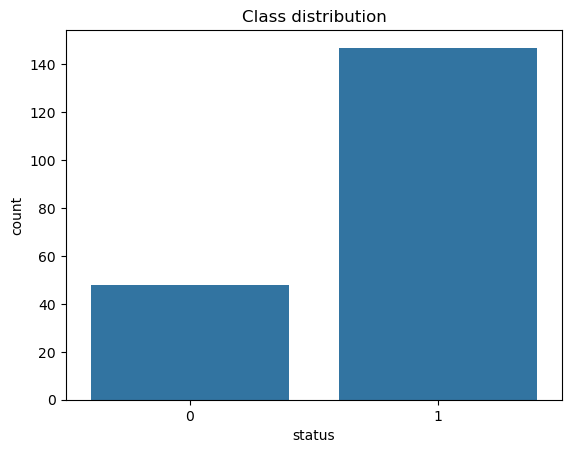

In [39]:
sns.countplot(x='status', data=df)
plt.title('Class distribution')
plt.show()

Correlation matrix

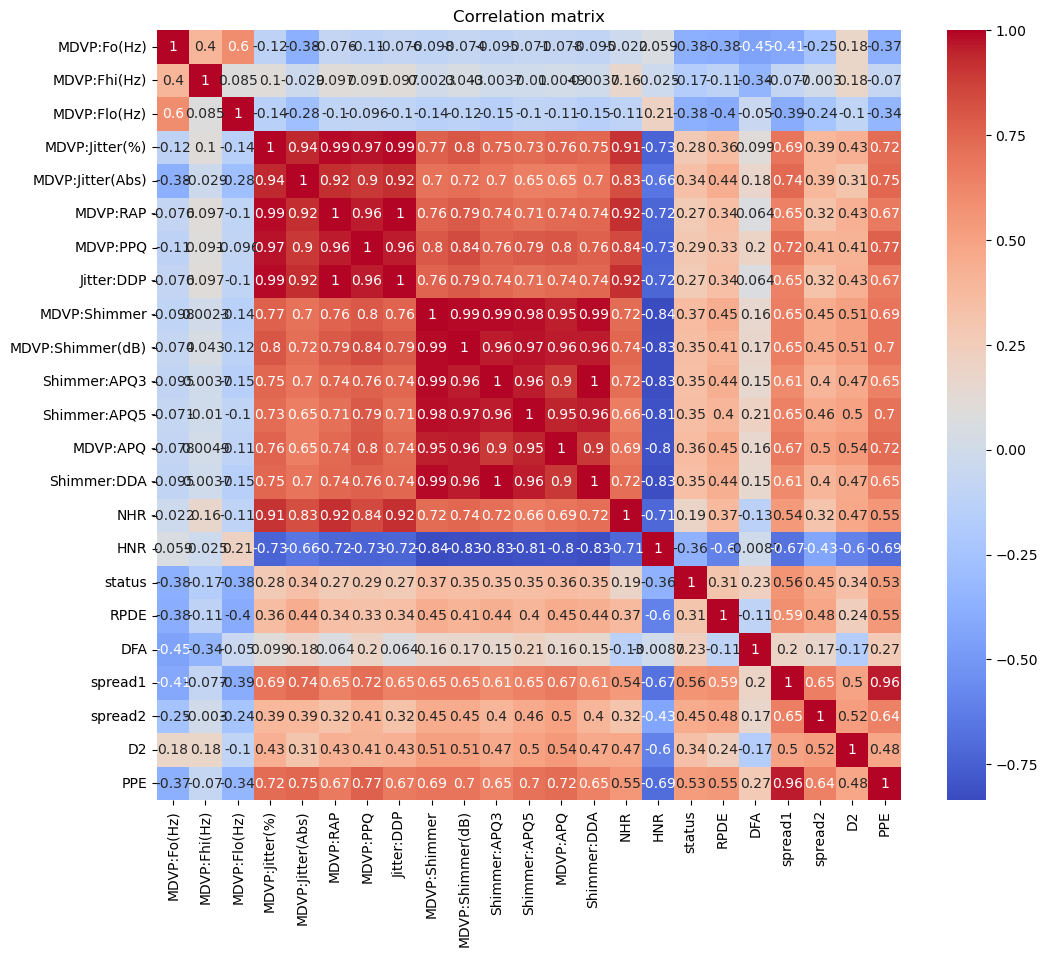

In [44]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

Histogram

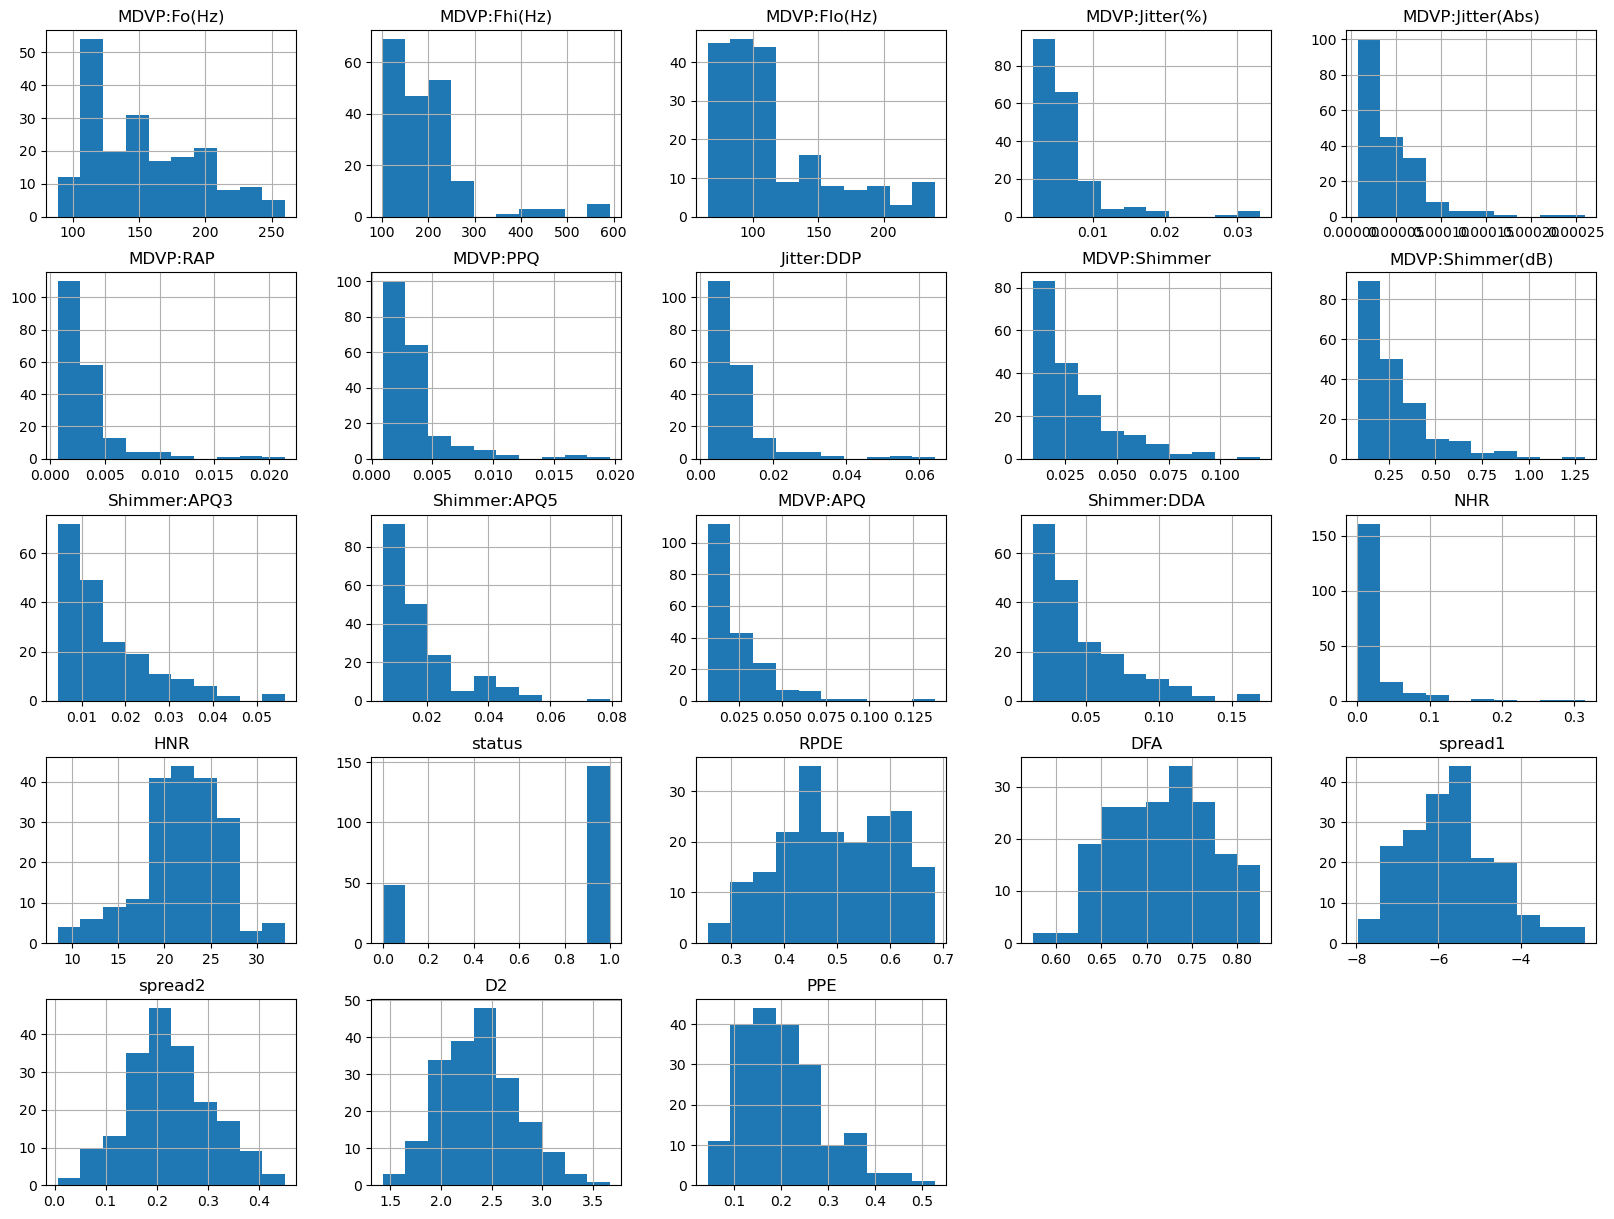

In [48]:
df.hist(figsize=(20,15));

Split data

In [56]:
X = df.drop(['name', 'status'], axis=1)  # 'name' не е релевантна
y = df['status']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Logistic Regression

In [59]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Evaulation

Accuracy: 0.8974358974358975
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.89      1.00      0.94        32

    accuracy                           0.90        39
   macro avg       0.94      0.71      0.77        39
weighted avg       0.91      0.90      0.88        39



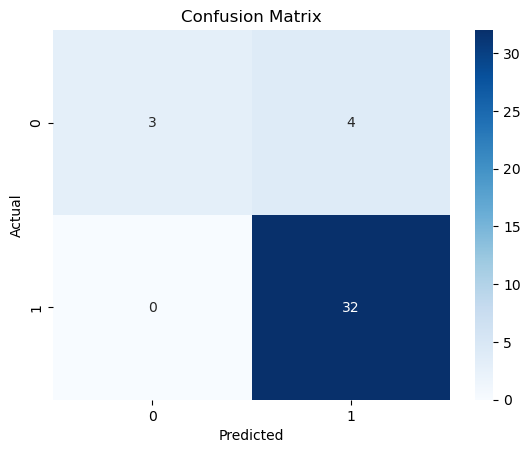

In [66]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

SVM

SVM Accuracy: 0.8974358974358975
SVM Report:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.89      1.00      0.94        32

    accuracy                           0.90        39
   macro avg       0.94      0.71      0.77        39
weighted avg       0.91      0.90      0.88        39



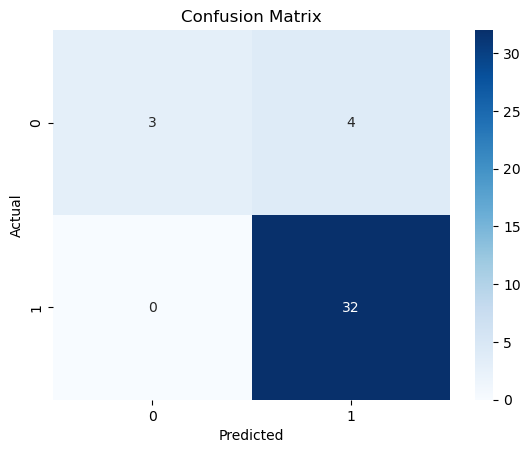

In [83]:
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("SVM Report:\n", classification_report(y_test, svm_pred))

conf_matrix = confusion_matrix(y_test, svm_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Random Forest

Random Forest Accuracy: 0.9487179487179487
Random Forest Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39



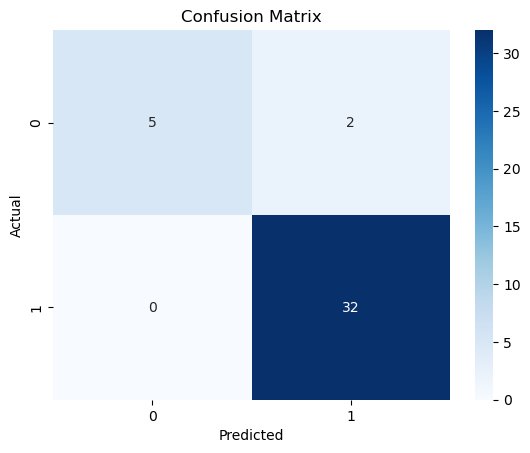

In [85]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("Random Forest Report:\n", classification_report(y_test, rf_pred))

conf_matrix = confusion_matrix(y_test, rf_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

KNN

KNN Accuracy: 0.9487179487179487
KNN Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39



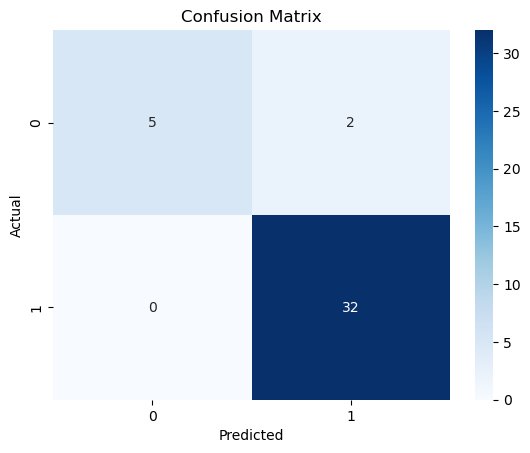

In [87]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, knn_pred))
print("KNN Report:\n", classification_report(y_test, knn_pred))

conf_matrix = confusion_matrix(y_test, knn_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Cross validation

In [94]:
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

print("Cross-validation (5-fold):\n")
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5)
    print(f"{name}: Mean Accuracy = {scores.mean():.4f} ± {scores.std():.4f}")

Cross-validation (5-fold):

Logistic Regression: Mean Accuracy = 0.8103 ± 0.0771
SVM: Mean Accuracy = 0.8462 ± 0.0778
Random Forest: Mean Accuracy = 0.7897 ± 0.0750
KNN: Mean Accuracy = 0.7795 ± 0.0661


Feature Importance анализа со Random Forest

In [103]:
importances = rf_model.feature_importances_
feature_names = df.drop(['name', 'status'], axis=1).columns

In [105]:
feat_importances = pd.Series(importances, index=feature_names)
top_features = feat_importances.sort_values(ascending=False).head(10)

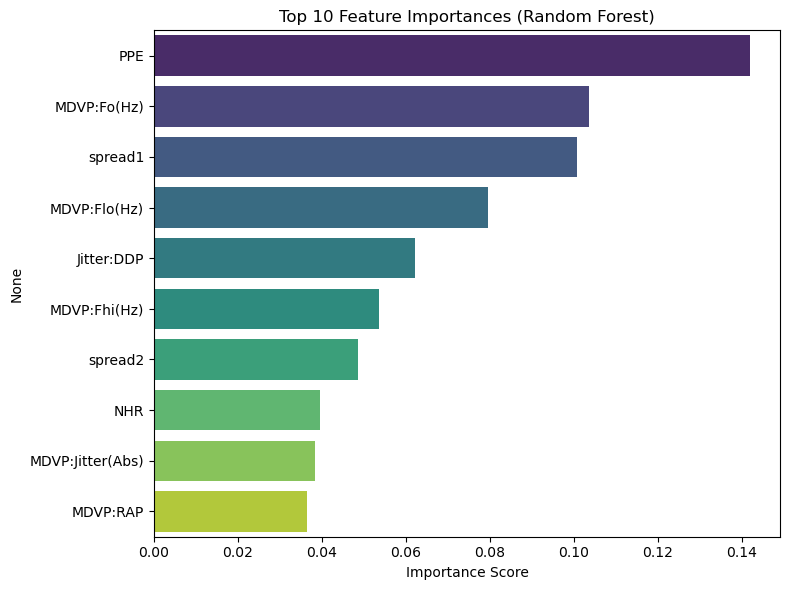

In [107]:
plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

PCA (Principal Component Analysis)

Целта е да намалиме димензии на податоците во 2D за визуелизација, и да видиме дали болните и здравите се разликуваат визуелно.

In [115]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

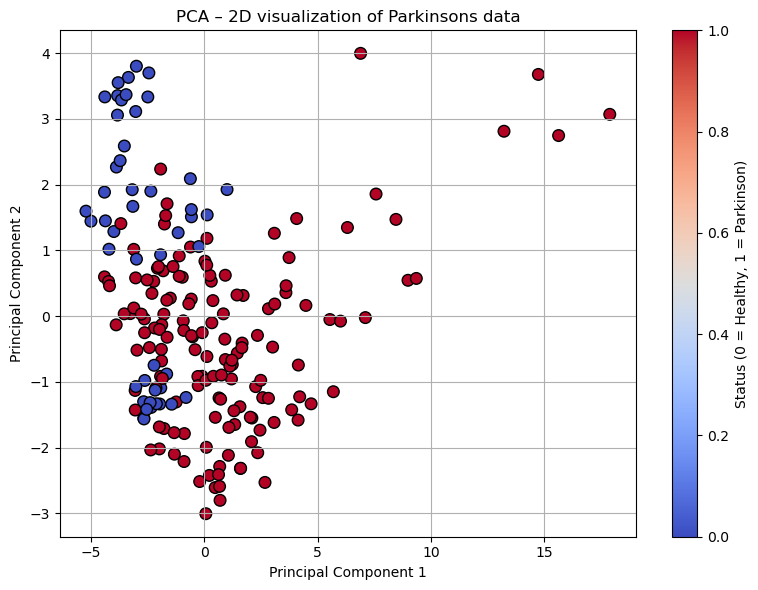

In [117]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=70)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA – 2D visualization of Parkinsons data')
plt.colorbar(label='Status (0 = Healthy, 1 = Parkinson)')
plt.grid(True)
plt.tight_layout()
plt.show()

Постојат одредени кластери и преклопувања, но воопштено гледано, црвените точки се порастурени и се шират повеќе кон десната страна на графикот (особено по првата компонента).
Сините точки (здравите пациенти) се повеќе групирани на левата страна.

Оваа визуелизација сугерира дека PCA успеала барем делумно да ги раздели двете класи (здрава и со Паркинсон), што е корисно при анализа или градење на класификациски модели.

TSNE

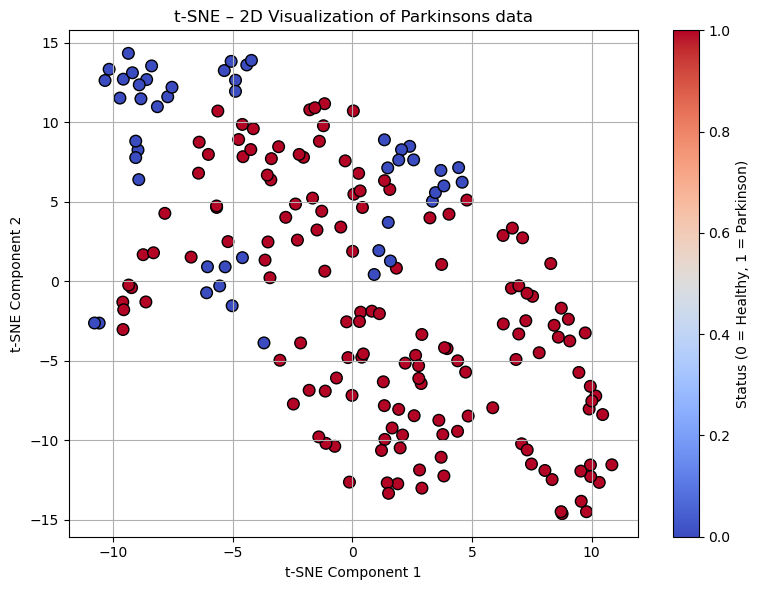

In [120]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=70)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE – 2D Visualization of Parkinsons data')
plt.colorbar(label='Status (0 = Healthy, 1 = Parkinson)')
plt.grid(True)
plt.tight_layout()
plt.show()
